In [1]:
from model import *
from train_test_split import *
from predictionsGraph import *
from data_set import *
from torch.utils.data import DataLoader
from data_set import weighted_mse_loss

In [2]:
seq_len = 5 #the value has to be the same as in training
batch_size = 1 #has to be equal to 1 for testing
hidden_dim = 64
attention = True
target='PRAM'
nr_days = 2
dropout=0.25
use_weights = False
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#fold should be changed according to the years used in training
fold = 7

rj_test_years = {1:[2014,2015], 2:[2015,2016], 3:[2016,2017], 4:[2017,2018], 5:[2018,2019], 6:[2019,2020], 7:[2020,2021]}
test_years = rj_test_years[fold]
valid_years = [y-2 for y in test_years]
exclude_years=[g for g in range(2000, 2022) if g>test_years[1]]

In [3]:
train_data, val_data, test_data = load_data(file_name=f'sim-30-{target}-jump_weights-real_for_all_NS_2000_2021.csv', test_years=test_years, valid_years=valid_years, exclude_years=exclude_years, preproc = 'lognormalize', target='PRAM', use_weights = use_weights)
train_dataset = Dataset(train_data, seq_len, nr_days, target)
val_dataset = Dataset(val_data, seq_len, nr_days, target)
test_dataset = Dataset(test_data, seq_len, nr_days, target)
input_dim = train_dataset[0][0].shape[1]
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)

model = Net(input_dim,  hidden_dim = hidden_dim, nr_days = nr_days, seq_len = seq_len, attention = attention, device = device)

In [4]:
path_to_model = f'models/PRAM/SMOD/batch_size_32-seq_len_{seq_len}-nr_days_{nr_days}-lr_0.001-hidd_dim_{hidden_dim}-att_{attention}-use_weights_{use_weights}-dropout_{dropout}-best.weights'
path_to_model = f'models/PRAM/SMSD/batch_size_1-seq_len_{seq_len}-nr_days_{nr_days}-lr_0.005-hidd_dim_{hidden_dim}-att_{attention}-use_weights_{use_weights}-dropout_{dropout}-best.weights'
model.load_state_dict(torch.load(path_to_model))
model.eval()

Net(
  (lstm): LSTM(7, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (lstm_cell): LSTMCell(6, 64)
  (sigmoid): Sigmoid()
  (attention): Attention(
    (W1): Linear(in_features=64, out_features=64, bias=True)
    (W2): Linear(in_features=128, out_features=64, bias=True)
    (softmax): Softmax(dim=1)
    (dropout): Dropout(p=0.25, inplace=False)
    (tanh): Tanh()
  )
)

In [5]:
def calculateMean(targ='PRAM', locations=['NS'], train_years=[2015, 2016], data = 'real_for_all_NS_2000_2021.csv'):
    #targ = targ
    data = pd.read_csv(data)
    data = data[[targ, 'GOD', 'LOK']]
    train_dataset = data[data['GOD'].isin(train_years)]
    MEAN = train_dataset[targ].mean()
    return MEAN

def returnTensorToStartingValues(t, mean):
    return (torch.exp(t)-1)*mean

MEAN = calculateMean(targ=target, locations=['NS'], train_years=[g for g in range(2000,2022) if g < valid_years[0]])

In [6]:
realValues = []
predictedValues = []
w = []
for dan in range(nr_days):
    realValues.append([])
    predictedValues.append([])
    w.append([])
model.to('cuda')

for (inputs, meteo, labels, weights) in test_loader:
    inputs, meteo, labels, weights = inputs.to(device), meteo.to(device), labels.to(device), weights.to(device)
    output = model(inputs, meteo)#, h)
    for dan in range(nr_days):
        realValues[dan].append(labels[0][dan].item())
        predictedValues[dan].append(output[0][dan].item())
        w[dan].append(weights[0][dan].item())

for dan in range(nr_days):
    realValues[dan] = torch.FloatTensor(realValues[dan])
    predictedValues[dan]= torch.FloatTensor(predictedValues[dan])
    w[dan]= torch.FloatTensor(w[dan])
    realValues[dan] = returnTensorToStartingValues(realValues[dan],MEAN)
    predictedValues[dan] = returnTensorToStartingValues(predictedValues[dan],MEAN)

In [7]:
naivePrediction = []
naivePrediction.append(realValues[0][0].item()) #the first day is equal to the real value, all the rest days have values copied from previous day
for i in range(1,len(realValues[0])):
    naivePrediction.append(realValues[0][i-1].item())
naivePrediction = torch.FloatTensor(naivePrediction)

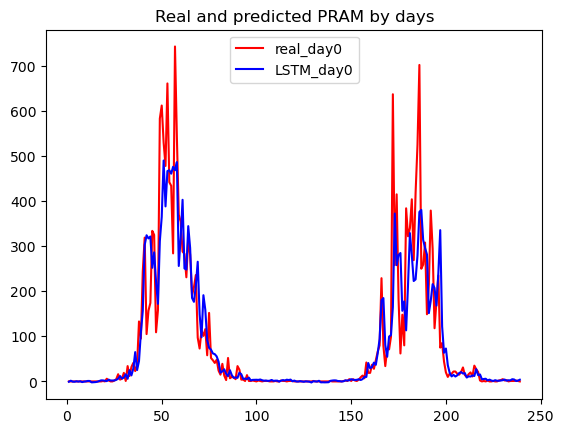

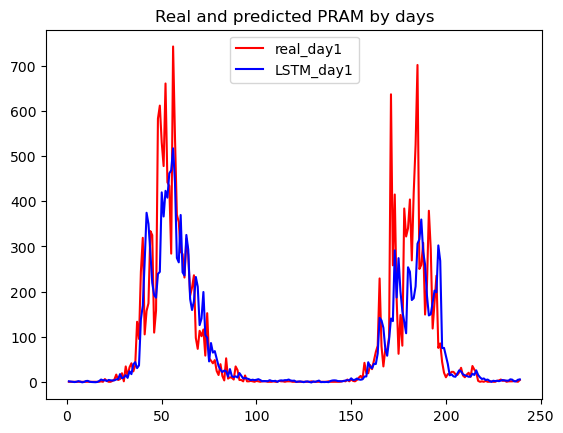

DAY 0  loss LSTM: tensor(75.1329) loss naive model: tensor(89.8943)
DAY 1  loss LSTM: tensor(84.5690) loss naive model: tensor(104.6039)


In [8]:
for dan in range(nr_days):
    predictionsGraph([realValues[dan], predictedValues[dan]], ['real_day'+str(dan), 'LSTM_day'+str(dan)],target)

loss_fn = nn.MSELoss(reduction='mean')
for dan in range(nr_days):
    loss1 = np.sqrt(loss_fn(realValues[dan], predictedValues[dan]))
    loss2 = np.sqrt(loss_fn(realValues[dan], naivePrediction))
    print('DAY',dan,' loss LSTM:',loss1,'loss naive model:', loss2)